# Extending Logistic Regression: 2015 American Community Survey

## Conrad Appel, Erik Gabrielsen, Danh Nguyen

### Preparation and Overview (30 points total)

[5 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results.

[10 points] (mostly the same processes as from lab one) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

[15 points] Divide you data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue for or against splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?  

### Modeling (50 points total)

[20 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template used in the course. You should add the following functionality to the logistic regression classifier:
Ability to choose optimization technique when class is instantiated: either steepest descent, stochastic gradient descent, or Newton's method. Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1/L2 norm of the weights). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  

[15 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term "C" to achieve the best performance on your test set. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?

[15 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time, training iterations, and memory usage while training. Discuss the results. 

### Deployment (10 points total)

Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

### Exceptional Work (10 points total)

You have free reign to provide additional analyses.
One idea: Make your implementation of logistic regression compatible with the GridSearchCV function that is part of scikit-learn.

## Data Overview

In this lab, we are investigating the relationship among working individuals' income and personal attributes as provided by the [2015 American Community Survey](https://www.kaggle.com/census/2015-american-community-survey). We used a subset of the entire dataset, which gave us around 1.5 million individual records to work with. 

Specifically, we want to see how well we can classify people's income based on their age, race, education level, degree, where they were born, marital status, military status, and time when they arrive and leave work. 

Marketing and advertising researchers may be interested in our work. They can try to predict their target audience's income based on certain attributes to determine how they should price their products. They can use this to bolster their market research surveys and see how their samples compare to census data.


In [3]:
## redoing large files
import pandas as pd
import numpy as np
%load_ext memory_profiler

# %time df = pd.read_csv('~/Downloads/ss15pusb.csv') # read in the csv file


In [ ]:
df.columns.values

In [205]:
df.head(10)
df.shape

new_df = df.filter(items=['AGEP','PINCP', 'MAR', 'MIL', 'SCHL','QTRBIR','JWAP','JWDP','YOEP','WAOB','RAC1P', 'FOD1P'])
new_df.shape
# new_df.to_csv('~/Downloads/ss15pusb3.csv')

(1528516, 12)

## Data Preparation 

We began with approximately 1.5 million records from the dataset and kept approximately 12 attributes of the almost 300 attributes tracked by the survey, and wrote it out to a CSV for reuse later on. Of the attributes we examine, Age, Personal Income, and Year of entry to the US are ordinal data represented as integers. The remaining attributes were recorded as discrete values in the dataset, and we continue using their integer representation. For instance, Time of Arrival at work is recorded as 1 for times between 12:00 a.m. and 12:04 a.m. For classification purposes, we cut income into fifths, with 0 being the 20% of people with the lowest income. The full list of attributes we are working with is displayed in the table below.


**Attribute**|**Description**|**Example**
:-----:|:-----:|:-----:
AGEP|Age| 
PINCP|Total person's income (signed)| 0 - bottom 20% of population, 4 - top 20% of population
YOEP|Year of entry to the US| 
QTRBIR|Quarter of birth|1 - January through March, 2 -  April through June, etc.
JWAP|Time of arrival at work |1 - 12:00 a.m. to 12:04 a.m., 2 - 12:05 a.m. to 12:09 a.m., etc.
JWDP|Time of departure for work|1 - 12:00 a.m. to 12:29 a.m., 2 - 12:30 a.m. to 12:59 a.m., etc.
WAOB|World area of birth|1 - US state, 2 - PR and US Island Areas, etc.
RAC1P|Recoded detailed race code|1 - White alone, 2 - Black or African American alone, etc.
MAR|Marital status|1 - Married, 2 - Widowed
MIL|Military Service |1 - Now on active duty, 4 - Never served in the military
SCHL|Educational attainment|23 - Professional degree beyond a bachelor's degree, 24 - Doctorate degree, etc.
FOD1P|Recoded field of degree|1904 - advertising and public relations, 2001 - communication technologies, etc.

In [4]:
%time new_df = pd.read_csv('~/Downloads/ss15pusb3.csv') # read in the csv file

CPU times: user 1.75 s, sys: 264 ms, total: 2.01 s
Wall time: 2.06 s


### Data Cleaning 

We delete all of the records younger than 18 to exclude the set to working individuals. Time of arival and departure are `NAN` for those who are not working, so we map this to a discrete value of 0. We also map the `NAN` values for those who do not have a college degree and were born in the united states to 0 for Field of Degree and Year of Entry, respectively. We then use quantile cut divide income into fifths for classification purpose.

In [5]:
# delete younger than 18
new_df = new_df[new_df.AGEP >= 18]

# find null columns
new_df.columns[new_df.isnull().any()].tolist()

['JWAP', 'JWDP', 'YOEP', 'FOD1P']

In [6]:
#new_df[new_df['JWAP'].isnull()]
# clean out JWAP and JWDP. They are ordinal variables, create a new one to classify them

df_grouped = new_df.groupby(by=['JWAP', 'JWDP'])
# new_df = new_df.groupby(by=['JWAP', 'JWDP']).transform('median')

new_df['JWAP'].fillna(0, inplace=True)
new_df['JWDP'].fillna(0, inplace=True)
new_df['FOD1P'].fillna(0, inplace=True)

## fill null values in YOEP (Year of entrance into US)
new_df['YOEP'].fillna(lambda x: , inplace=True)

new_df.columns[new_df.isnull().any()].tolist()

[]

In [7]:
new_df[pd.isnull(new_df).any(axis=1)]
new_df.dropna(inplace=True)
new_df.drop(new_df.columns[0], axis=1, inplace=True)
new_df.head()

,AGEP,PINCP,MAR,MIL,SCHL,QTRBIR,JWAP,JWDP,YOEP,WAOB,RAC1P,FOD1P
0,77,9100.0,3,4.0,16.0,1,0.0,0.0,0.0,1,1,0.0
1,30,5000.0,1,4.0,11.0,2,0.0,0.0,0.0,1,1,0.0
2,65,20000.0,1,4.0,22.0,4,0.0,0.0,0.0,1,1,5404.0
3,69,11000.0,1,4.0,16.0,2,0.0,0.0,0.0,1,1,0.0
4,24,25300.0,1,4.0,21.0,2,82.0,34.0,0.0,1,1,3600.0


In [8]:
# new_df['PINCP'] = pd.cut(new_df.PINCP,[0,20000,60000,100000,150000,1e8],5,labels=[0,1,2,3,4]) # this creates a new variable

new_df['PINCP'] = pd.qcut(new_df.PINCP, 5, labels=[0,1,2,3,4])
# 4. drop rows that still had missing values after grouped imputation
new_df.dropna(inplace=True)
new_df['PINCP'] = new_df['PINCP'].astype(np.int)

In [9]:
for value in new_df.PINCP.unique(): 
    print(len(new_df[new_df['PINCP'] == value]))

251045
241657
234571
241334
238193


In [10]:
new_df.info()
new_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206800 entries, 0 to 1528515
Data columns (total 12 columns):
AGEP      1206800 non-null int64
PINCP     1206800 non-null int64
MAR       1206800 non-null int64
MIL       1206800 non-null float64
SCHL      1206800 non-null float64
QTRBIR    1206800 non-null int64
JWAP      1206800 non-null float64
JWDP      1206800 non-null float64
YOEP      1206800 non-null float64
WAOB      1206800 non-null int64
RAC1P     1206800 non-null int64
FOD1P     1206800 non-null float64
dtypes: float64(6), int64(6)
memory usage: 119.7 MB


,AGEP,PINCP,MAR,MIL,SCHL,QTRBIR,JWAP,JWDP,YOEP,WAOB,RAC1P,FOD1P
0,77,1,3,4.0,16.0,1,0.0,0.0,0.0,1,1,0.0
1,30,0,1,4.0,11.0,2,0.0,0.0,0.0,1,1,0.0
2,65,2,1,4.0,22.0,4,0.0,0.0,0.0,1,1,5404.0
3,69,1,1,4.0,16.0,2,0.0,0.0,0.0,1,1,0.0
4,24,2,1,4.0,21.0,2,82.0,34.0,0.0,1,1,3600.0


### Training and Test Sets

We used scikit learn to randomly select 80% of our dataset for training classifiers and 20% of our dataset for testing. Since we used quantile cut to evenly split our dataset and balance the income classes, the 80-20 split is appropriate for our purposes

In [11]:
from sklearn.cross_validation import ShuffleSplit
df_imputed = new_df.copy()
# we want to predict the X and y data as follows:
if 'PINCP' in new_df:
    y = df_imputed['PINCP'].values # get the labels we want
    del df_imputed['PINCP'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 1
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(1206800, n_iter=1, test_size=0.2, random_state=None)


/Users/danh/anaconda/envs/machinelearning/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Modeling

In [29]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object: 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    %time %memit lr_clf.fit(X_train,y_train)  # train object
    %time %memit y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

peak memory: 768.67 MiB, increment: 211.11 MiB
CPU times: user 1min 56s, sys: 2.22 s, total: 1min 59s
Wall time: 2min 2s
peak memory: 558.98 MiB, increment: 21.66 MiB
CPU times: user 158 ms, sys: 59.9 ms, total: 218 ms
Wall time: 254 ms
====Iteration 0  ====
accuracy 0.430518727212
confusion matrix
 [[32755  8252  2268  1689  3358]
 [13030 21950  4796  4318  6261]
 [ 6518 14431  6973  8376 10673]
 [ 4080  7877  5901 10387 19237]
 [ 3227  3275  3133  6750 31845]]


In [67]:
# confusion matrix accuracy per class
conf2 = conf.copy()
for i in range(0,len(conf2)):
    print("Accuracy for income bracket ", i, "=",conf[i][i]/sum(conf[i]))
    class_total = sum(conf[i])
    print(class_total)
    for j in range(0, len(conf2)):
        conf2[i][j] = conf2[i][j]/class_total*100

Accuracy for income bracket  0 = 0.677848598982
48322
Accuracy for income bracket  1 = 0.435905073975
50355
Accuracy for income bracket  2 = 0.148453300973
46971
Accuracy for income bracket  3 = 0.218756581441
47482
Accuracy for income bracket  4 = 0.660273688576
48230


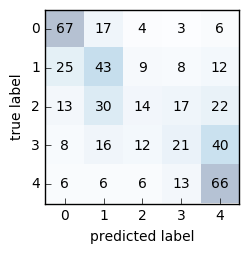

In [69]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
fig, ax = plot_confusion_matrix(conf_mat=conf2)
plt.show()

## Custom Logistic Regression Classifier

In [12]:
import numpy as np
import pandas as p
from scipy.optimize import fmin_bfgs
from scipy.special import expit
from sklearn.model_selection import GridSearchCV
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

In [13]:
class BinaryClassifierBase:
    def __init__(self, eta, iterations=20, cost=0.001, norm=2):
        self.eta = eta
        self.cost = cost
        self.iters = iterations
        self.norm = norm
    
    def normalize(self, w, gradient):
        # regularization (does both if 3)
        if self.norm & 1: # L1 norm
            gradient[1:] += -1 * w[1:] * self.cost
        elif self.norm & 2: # L2 norm
            gradient[1:] += -2 * w[1:] * self.cost
    
    def fit(self, x, y):
        self.w_ = np.zeros((x.shape[1],1))
        for _ in range(self.iters):
            gradient = self._get_gradient(x,y)
            self.normalize(self.w_, gradient)
            self.w_ += gradient*self.eta
    
    def predict_proba(self,x):
        return 1/(1+np.exp(-(x @ self.w_)))
    
    def predict(self, x):
        return (self.predict_proba(x)>0.5)
    
    
class BinaryStochDescClassifier(BinaryClassifierBase):
    def _get_gradient(self, x, y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(x[idx]) # get y difference (now scalar)
        gradient = x[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        return gradient
    
    
class BinarySteepDescClassifier(BinaryClassifierBase):
    def _get_gradient(self, x, y):
        ydiff = y-self.predict_proba(x).ravel()
        gradient = np.mean(x * ydiff[:,np.newaxis], axis=0)
        return gradient.reshape(self.w_.shape)

    
class BinaryNewtonClassifier(BinaryClassifierBase):
    def fit(self, x, y):
        def obj_fn(w, x, y, c):
            g = expit(x @ w)
            return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + c*sum(w**2)
        
        def obj_grad(w, x, y, c):
            g = expit(x @ w)
            ydiff = y-g
            gradient = np.mean(x * ydiff[:,np.newaxis], axis=0)
            gradient = gradient.reshape(w.shape)
            self.normalize(w, gradient)
            return -gradient
        
        self.w_ = fmin_bfgs(obj_fn, 
                            np.zeros((x.shape[1], 1)), 
                            fprime=obj_grad, 
                            args=(x, y, self.cost), 
                            gtol=1e-03, 
                            maxiter=self.iters,
                            disp=False).reshape((x.shape[1], 1))

        
class LogRegClassifier:
    def __init__(self, eta, iterations=20, optimize='steepdesc', cost=0.001, norm=2):
        typesofoptimize = {
            'steepdesc': BinarySteepDescClassifier, 
            'stochdesc': BinaryStochDescClassifier, 
            'newton': BinaryNewtonClassifier
        }
        if optimize not in typesofoptimize.keys():
            raise ValueError('optimize must be one of: ' + ' '.join(typesofoptimize.keys()))
        
        self.eta = eta
        self.iters = iterations
        self.optimize = optimize
        self.classifier = typesofoptimize[optimize]
        self.cost = cost
        self.norm = norm
        self.classifiers = [] # fill with binary classifiers during fit
    
    def _add_bias(self, x):
        return np.hstack((np.ones((x.shape[0],1)),x))
    
    def fit(self, x, y):
        Xb = self._add_bias(x)
        classes = np.unique(y)
        
        for cl in classes:
            cur_y = y==cl
            cur_classifier = self.classifier(self.eta, self.iters, cost=self.cost, norm=self.norm)
            cur_classifier.fit(x, cur_y)
            self.classifiers.append(cur_classifier)
    
    def predict(self, x):
        if not self.classifiers:
            raise RuntimeError('Classifier not fit!')
        
        probabilities = []
        for classifier in self.classifiers:
            probabilities.append(classifier.predict_proba(x))
        probabilities = np.hstack(probabilities)
        return np.argmax(probabilities,axis=1)

In [14]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
ds = load_iris()
kwargs = {
    'norm': 2,
    'cost': .1,
    'iterations': 500
}
regrs = {
    'newton': LogRegClassifier(.1, optimize='newton', **kwargs),
    'stoch': LogRegClassifier(.1, optimize='stochdesc', **kwargs), # Different results every time, random
    'steep': LogRegClassifier(.1, optimize='steepdesc', **kwargs)
}
for regr in regrs.values():
    %memit regr.fit(ds.data, ds.target)

for key, val in regrs.items():
    %memit res = val.predict(ds.data)
    print(key + ': ' +str(accuracy_score(ds.target, res)))

peak memory: 631.20 MiB, increment: -43.04 MiB
peak memory: 589.49 MiB, increment: -35.66 MiB
peak memory: 584.51 MiB, increment: -4.98 MiB
peak memory: 581.36 MiB, increment: -3.16 MiB
steep: 0.813333333333
peak memory: 581.37 MiB, increment: 0.00 MiB
newton: 0.813333333333
peak memory: 581.37 MiB, increment: 0.00 MiB
stoch: 0.186666666667


In [15]:
for train_indices, test_indices in cv_object:
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]

    kwargs = {
        'norm': 2,
        'cost': .1,
        'iterations': 500
    }

    %memit lr = LogRegClassifier(.1, optimize='steepdesc', **kwargs)
    %memit lr.fit(X_train,y_train)
    print(lr)

    yhat = lr.predict(X_test)

    print('Accuracy of: ',accuracy_score(y_test,yhat))

peak memory: 795.34 MiB, increment: 0.00 MiB
peak memory: 978.89 MiB, increment: 183.55 MiB
Accuracy of:  0.285813722241


In [21]:
class LogRegClassifier:
    def __init__(self, eta=.0001, iters=20, optimize='steepdesc', cost=0.001, norm=2):
        self._set_optimization(optimize)
        self.eta = eta
        self.iters = iters
        self.cost = cost
        self.norm = norm
        
        self.classifiers = [] # fill with binary classifiers during fit
        self._estimator_type = 'classifier'
    
    def _add_bias(self, x):
        return np.hstack((np.ones((x.shape[0],1)),x))
    
    def _set_optimization(self, optimize):
        typesofoptimize = {
            'steepdesc': BinarySteepDescClassifier, 
            'stochdesc': BinaryStochDescClassifier, 
            'newton': BinaryNewtonClassifier
        }
        if optimize not in typesofoptimize.keys():
            raise ValueError('optimize must be one of: ' + ' '.join(typesofoptimize.keys()))
            
        self.optimize = optimize
        self.classifier = typesofoptimize[optimize]
        
    def fit(self, x, y):
        x, y = check_X_y(x, y)
        
        Xb = self._add_bias(x)
        self.classes_ = np.unique(y)
        self.X_ = x
        self.y_ = y
        
        for cl in self.classes_:
            cur_y = y==cl
            cur_classifier = self.classifier(self.eta, self.iters, cost=self.cost, norm=self.norm)
            cur_classifier.fit(x, cur_y)
            self.classifiers.append(cur_classifier)
        return self
    
    def predict(self, x):
        check_is_fitted(self, ['X_', 'y_'])
        x = check_array(x)
        
        probabilities = []
        for classifier in self.classifiers:
            probabilities.append(classifier.predict_proba(x))
        probabilities = np.hstack(probabilities)
        return np.argmax(probabilities,axis=1)
    
    def score(self, x, y):
        res = self.predict(x)
        return accuracy_score(y, res)
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
            
    def get_params(self, deep=True):
        return {
            'eta': self.eta,
            'iters': self.iters,
            'optimize': self.optimize,
            'cost': self.cost,
            'norm': self.norm
        }
    
# check_estimator(LogRegClassifier)

import numpy as np
import pandas as p
from scipy.optimize import fmin_bfgs
from scipy.special import expit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score

params = {
    "optimize": ['newton', 'stochdesc', 'steepdesc'],
    "eta": [.0001, .001, .01, .1, .25, .5],
    "norm": [0, 1, 2, 3],
    "cost": [.0001, .001, .01, .1, .25, .5]
}
cv = GridSearchCV(LogRegClassifier(), params, n_jobs=-1)
random_search = RandomizedSearchCV(LogRegClassifier(), params, n_jobs=-1)
%time %memit random_search.fit(X_train, y_train)
print('Best score: '+str(random_search.best_score_))
y_hat = random_search.predict(X_test)

conf = mt.confusion_matrix(y_test,y_hat)
print("confusion matrix\n",conf)
print(random_search.best_params_)

# %memit cv.fit(X_train, y_train)
# print('Best score: '+str(cv.best_score_))
# y_hat = cv.predict(X_test)

# conf = mt.confusion_matrix(y_test,y_hat)
# print("confusion matrix\n",conf)
# print(cv.best_params_)

peak memory: 619.07 MiB, increment: 322.47 MiB
CPU times: user 20.7 s, sys: 2.76 s, total: 23.5 s
Wall time: 1min 53s
Best score: 0.349110250249
confusion matrix
 [[24840  9970     0     0 13551]
 [11215 20065     0     0 18969]
 [ 6739 13302     0     0 26841]
 [ 4330  8792     0     0 34488]
 [ 2635  4873     0     0 40750]]
{'optimize': 'steepdesc', 'cost': 0.1, 'eta': 0.001, 'norm': 0}
